<a href="https://colab.research.google.com/github/liana-zhu/Detection-of-Nanoplastic-and-SH-SY5Y-Human-Neuroblastoma-Cell-Binding-Sites/blob/main/EllipseFitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Init

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

chunk = 1

def smooth_image_alt(matrix, chunk_size=1, offset=(0,0)):
    n_rows, n_cols = matrix.shape
    result = np.zeros_like(matrix, dtype=float)

    offset_x, offset_y = offset

    for i in range(n_rows):
        for j in range(n_cols):
            # Determine surrounding indices with chunk size and offset
            min_i = max(i + offset_x - chunk_size, 0)
            max_i = min(i + offset_x + chunk_size, n_rows - 1)
            min_j = max(j + offset_y - chunk_size, 0)
            max_j = min(j + offset_y + chunk_size, n_cols - 1)

            # Calculate sum of surrounding pixels including the pixel itself
            sum_neighbors = np.sum(matrix[min_i:max_i+1, min_j:max_j+1])
            count_neighbors = (max_i - min_i + 1) * (max_j - min_j + 1)

            # Calculate mean of surrounding cells
            mean_value = sum_neighbors / count_neighbors

            result[i, j] = mean_value

    return result


def round_to_nearest_block(v, subdiv):
    # Calculate the size of each block
    block_size = 1

    # Find the nearest block
    rounded_value = round(v / block_size) * block_size

    # Ensure the result is within the valid range [0, 255]
    rounded_value = max(0, min(255, rounded_value))

    return int(rounded_value)

def smooth_image(image_array, block_size):
    # Get image dimensions
    height, width = image_array.shape[:2]

    # Handle the case where height or width is not a multiple of block_size
    new_height = height - height % block_size
    new_width = width - width % block_size

    # Determine the number of channels
    if len(image_array.shape) == 3:
        channels = image_array.shape[2]
    else:
        channels = 1

    # Create a new array to store the smoothed image
    if channels > 1:
        smoothed_array = np.zeros((new_height // block_size, new_width // block_size, channels), dtype=image_array.dtype)
    else:
        smoothed_array = np.zeros((new_height // block_size, new_width // block_size), dtype=image_array.dtype)

    # Loop through the image by nxn blocks and compute the average
    for y in range(0, new_height, block_size):
        for x in range(0, new_width, block_size):
            block = image_array[y:y+block_size, x:x+block_size]
            smoothed_array[y//block_size, x//block_size] = np.mean(block, axis=(0, 1))

    return smoothed_array

def normalize(image_array, scale=1):
    normalized_image = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array)) * 255 * scale
    normalized_image = normalized_image.astype(np.uint8)
    return normalized_image

def process_image(image, smooth=4):
  # Convert image to numpy array
  image_array = np.array(image)

  #Manipulation so that will be easier for the contour to detect.
  image_array = smooth_image_alt(image_array, smooth)

  mean = np.mean(image_array)
  normal = normalize(image_array, 2*mean/255)

  return normal

Getting contours

In [ ]:
def get_contours(normalized):
  subdiv = 256

  contours = []

  for j in range(0, (255//subdiv)+1):
      # Need to find magic values for subdiv and max_val
      binary_image = [[round_to_nearest_block(pixel+j, subdiv) for pixel in row] for row in normalized]

      for i in range(0, subdiv):
          img = np.array(binary_image)

          max_val = i
          img = img <= 255*(max_val/subdiv)
          img = (img*255).astype(np.uint8)

          temp, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
          contours.extend(temp)

  # print(f"{len(contours)} potential ellipses.")
  return contours

Alternative contours

In [ ]:
def get_alt_contours(normalized):
  contours = []

  for i in range(0, 255):
      img = normalized <= i
      img = (img*255).astype(np.uint8)

      temp, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
      contours.extend(temp)

      img = normalized >= i
      img = (img*255).astype(np.uint8)

      temp, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
      contours.extend(temp)

  print(f"{len(contours)} potential ellipses.")
  return contours

Custom Contour Parsing (Doesn't work, don't try it, unless you maybe want to fix it up)

In [ ]:
def get_custom_contours(normalized):
    contours = []

    res = np.array(normalized).astype(np.float64)
    res /= 255

    res = (res**4)
    res *= 255/np.max(res)

    res = 255 - res
    res -= np.min(res)
    res /= np.max(res)

    for i in range(0, 10):
        res -= 1/10
        res[res<0] = 0

        show = np.max(res) - res
        show = normalize(show)
        contours.extend(get_alt_contours(show))

    return contours

Variables to filter ellipses

In [ ]:
#New Magic numbers...
minWidth, minHeight, maxHeight, maxAngleDeviation, whRatio = 15, 12, 120, 6, 3.75

minWidth /= chunk
minHeight /= chunk
maxHeight /= chunk

Get the raw ellipses and output them

In [ ]:
def get_raw_ellipse(normalized, contours):
  # Get image dimensions
  height, width = normalized.shape[:2]

  # Display the image with detected ellipses
  fig, ax = plt.subplots(ncols=1, nrows=1)
  ax.imshow(np.array(normalized), cmap='gray')

  num_horizontal_ellipses = 0

  # Fit ellipses to contours
  for contour in contours:
      if len(contour) >= 5:  # Need at least 5 points to fit an ellipse
          ellipse = cv2.fitEllipse(contour)
          (x, y), (MA, ma), angle = ellipse

          # Check for horizontal ellipses
          if ma <= MA: continue
          if np.isnan(MA/ma): continue
          if (ma/(MA+0.1)) <= whRatio: continue

          # Some more validation thing here
          if ma < minHeight or ma > maxHeight: continue
          if MA < minWidth: continue
          if abs(90-angle) > maxAngleDeviation: continue

          num_horizontal_ellipses += 1
          ellipse_points = cv2.ellipse2Poly((int(x)*chunk, int(y)*chunk), (int(MA / 2)*chunk, int(ma / 2)*chunk), int(angle), 0, 360, 1)
          ax.plot(ellipse_points[:, 0], ellipse_points[:, 1], color='red')

  plt.title('Detected Ellipses')
  plt.show()

  print(f"{num_horizontal_ellipses} raw ellipses found.")

Get filtered ellipses without overlap

In [ ]:
from shapely.geometry import Polygon
import math

# Function to calculate the area of an ellipse
def ellipse_area(ellipse):
    _, (MA, ma), _ = ellipse
    return np.pi * (MA / 2) * (ma / 2)

# Function to calculate overlap percentage between two ellipses
def calculate_overlap(ellipse1, ellipse2):
    poly1 = Polygon(cv2.ellipse2Poly((int(ellipse1[0][0]), int(ellipse1[0][1])), (int(ellipse1[1][0] / 2), int(ellipse1[1][1] / 2)), int(ellipse1[2]), 0, 360, 1))
    poly2 = Polygon(cv2.ellipse2Poly((int(ellipse2[0][0]), int(ellipse2[0][1])), (int(ellipse2[1][0] / 2), int(ellipse2[1][1] / 2)), int(ellipse2[2]), 0, 360, 1))
    try:
        if not poly1.intersects(poly2):
            return 0
    except:
        return 0
    intersection_area = poly1.intersection(poly2).area
    smaller_area = min(ellipse_area(ellipse1), ellipse_area(ellipse2))
    return intersection_area / smaller_area

# Calculates the distance from one ellipse's center to another
def calculate_overlap_euclidian(center1, center2):
  # parameters are tuples (x, y) of center
  return (center2[0] - center1[0])**2 + (center2[1] - center1[1])**2
  # not sqrt since waste of computation and we only want relative distances

def get_filtered_ellipse(normalized, contours, filename="Image"):
  height, width = normalized.shape[:2]

  fig, ax = plt.subplots(ncols=1, nrows=1)
  ax.imshow(np.array(normalized), cmap='gray')

  num_horizontal_ellipses = 0

  # List to store valid ellipses
  valid_ellipses = []

  # Fit ellipses to contours
  for contour in contours:
      if len(contour) >= 5:  # Need at least 5 points to fit an ellipse
          ellipse = cv2.fitEllipse(contour)
          (x, y), (MA, ma), angle = ellipse

          # Check for horizontal ellipses
          if ma <= MA: continue
          if np.isnan(MA/ma): continue
          if (ma/(MA+0.1)) <= whRatio: continue

          # Additional validation
          if ma < minHeight or ma > maxHeight: continue
          if MA < minWidth: continue
          if abs(90-angle) > maxAngleDeviation: continue

          # Check for overlap with previously detected ellipses
          keep_ellipse = True
          for existing_ellipse in valid_ellipses:
              if calculate_overlap(ellipse, existing_ellipse) > 0.2:
                  (x2, y2), (MA2, ma2), angle2 = existing_ellipse
                  if ellipse_area(ellipse) > ellipse_area(existing_ellipse) and abs(90-angle) < abs(90-angle2):
                      valid_ellipses.remove(existing_ellipse)
                      valid_ellipses.append(ellipse)
                  keep_ellipse = False
                  break

          if keep_ellipse:
              valid_ellipses.append(ellipse)

  #Easier to see ellipses:
  buffer = 0

  # Draw valid ellipses
  white_ellipses = 0
  black_ellipses = 0
  print("DHWIUHDAIUDH", valid_ellipses)
  for ellipse in valid_ellipses:
      (x, y), (minor, major), angle = ellipse
      if angle > 90: continue # skip obtuse angles
      # angle = 80 # DELETE LATER
      ellipse_points = cv2.ellipse2Poly((int(x), int(y)), (int(minor / 2) + buffer, int(major / 2) + buffer), int(angle), 0, 360, 1)
      point_x = []
      point_y = []
      for point in ellipse_points:
        x = point[0]
        y = point[1]
        if x < 0 or y < 0 or x > normalized.shape[1] or y > normalized.shape[0]:
          continue
        point_x.append(x)
        point_y.append(y)
      ax.plot(point_x, point_y, color='red')
      num_horizontal_ellipses += 1
      print(x, y, angle)
      if count_center(normalized, ellipse):
        ax.plot(x - np.abs(np.sin(np.deg2rad(angle))) * major / 2, y - np.abs(np.cos(np.deg2rad(angle))) * major / 2, marker='x', color="blue")
        ax.plot(min(normalized.shape[1] - 1, max(x + np.cos(np.abs(90 - angle)) *  major / 2, 0)), min(max(y - np.sin(np.abs(90 - angle)) * major / 2, 0), normalized.shape[0] - 1), marker='x', color="white")
        white_ellipses += 1
      else:
        ax.plot(x - np.abs(np.sin(np.deg2rad(angle))) * major / 2, y - np.abs(np.cos(np.deg2rad(angle))) * major / 2, marker='x', color="black")

        # ax.plot(min(normalized.shape[1] - 1, max(x - major / 2, 0)), min(max(y, 0), normalized.shape[0] - 1), marker='x', color="black")
        black_ellipses += 1

  plt.title('Detected Ellipses')
  plt.show()

  print(f"{num_horizontal_ellipses} final ellipses found. {white_ellipses} white ellipses. {black_ellipses} black ellipses.")

def count_center(normalized, ellipse):
  # Counts number of brighter/darker pixels in an ellipse
  # boolean output, true if center is white
  brightPixels = 0
  darkPixels = 0
  # when traversing normalized, use (y, x) indices
  (h, k), (minor, major), angle = ellipse # minor, major -> somehow second number in tuple is larger than first

  # h-major/4, h+major/4 to search within a smaller sub-ellipse of the ellipse
  # max and min used to prevent negative / out of bound indices
  for x in range(max(int(h-major/2), 0), min(int(h+major/4), normalized.shape[1] - 1)):
    for y in range(max(int(k-minor/4), 0), min(int(k+minor/4), normalized.shape[0] - 1)):
      if normalized[y, x] > np.mean(normalized): #Originally RHS was a constant
        brightPixels += 1
      else:
        darkPixels += 1

  if brightPixels > darkPixels:
    return True
  return False

def detect_center(normalized, ellipse):
  numPixels = 0
  pixelSum = 0
  (h, k), (MA, ma), angle = ellipse

  for x in range(max(int(h - MA), 0), min(int(h + MA), normalized.shape[1] - 1)):
    for y in range(max(int(k - ma), 0), min(int(k), normalized.shape[0] - 1)):
      if (y < ((x - h)**2/(MA**2) + (y - k)**2/(ma**2))):
        numPixels += 1
        pixelSum += normalized[y, x]
    for y in range(max(int(k), 0), min(int(k + ma), normalized.shape[0] - 1)):
      if (y > ((x - h)**2/(MA**2) + (y - k)**2/(ma**2))):
        numPixels += 1
        pixelSum += normalized[y, x]

  mean = pixelSum / numPixels

  if mean < np.mean(normalized):
    return False
  else:
    return True


def detect_center_alt(normalized, ellipse):
  (h, k), (MA, ma), angle = ellipse

  block = normalized[int(k - ma):int(k + ma), int(h - ma):int(h + ma)]
  mean = np.mean(block, axis=(0, 1))

  print(block, mean)

  if (mean < np.mean(normalized)):
    return False
  return True


In [ ]:
def loop(frames, prefix="/content/frame_"):
  for i in range(1, 1+1):
    filename = prefix + f'{i:03}' + ".png"
    image = Image.open(filename).convert('L')
    baseImage = np.array(image)
    image = process_image(image)
    contours = get_contours(image)
    get_filtered_ellipse(baseImage, contours, filename)

def single_frame(filename="/content/image.jpg"):
    image = Image.open(filename).convert('L')
    baseImage = np.array(image)
    # Deep search
    contours = []
    for i in range(2, 6):
        image = process_image(image, i)
        contours.extend(get_contours(image))
    get_raw_ellipse(baseImage, contours) # For analysis
    get_filtered_ellipse(baseImage, contours, filename)


# single_frame("/content/frame99to100.png")

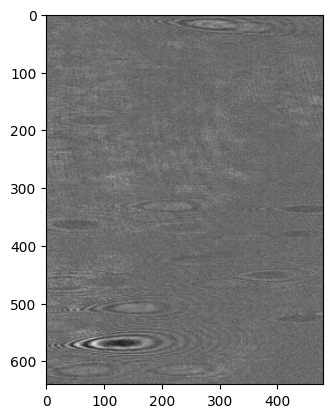

DHWIUHDAIUDH [((274.05389404296875, 14.966105461120605), (19.92026138305664, 89.50321197509766), 89.44464874267578), ((271.08111572265625, 418.5591735839844), (15.819562911987305, 106.14903259277344), 84.45990753173828), ((444.4081726074219, 337.2012023925781), (15.092198371887207, 70.11042785644531), 88.91874694824219), ((383.31463623046875, 450.00213623046875), (15.537408828735352, 59.052818298339844), 88.9642562866211), ((126.58026123046875, 568.9049682617188), (16.4466495513916, 66.81046295166016), 88.29121398925781), ((52.14018249511719, 363.64398193359375), (18.432811737060547, 72.18719482421875), 90.51307678222656), ((81.2215576171875, 183.5272216796875), (16.6564998626709, 82.52052307128906), 89.54689025878906), ((51.316307067871094, 7.698845386505127), (19.972625732421875, 76.24364471435547), 93.44367980957031), ((209.19061279296875, 332.043212890625), (17.347421646118164, 89.87045288085938), 88.99128723144531), ((157.5585479736328, 506.41949462890625), (18.455154418945312, 75

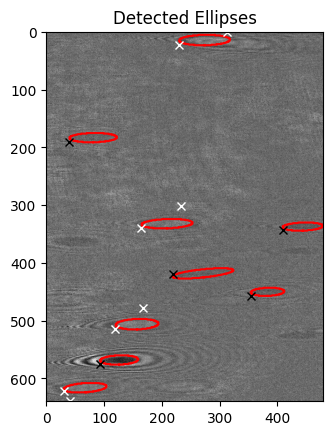

9 final ellipses found. 4 white ellipses. 5 black ellipses.


In [ ]:
# testing a single frame
filename = "/content/frame99to100.png"
image = Image.open(filename).convert('L')
original = np.array(image)
plt.imshow(image, cmap='gray')
plt.show()
image = process_image(image)
contours = get_contours(image)
get_filtered_ellipse(original, contours)

In [ ]:
def get_filtered_ellipse_single_plot(ax, alpha_value, original, normalized, contours):
  num_horizontal_ellipses = 0

  # List to store valid ellipses
  valid_ellipses = []

  # Fit ellipses to contours
  for contour in contours:
      if len(contour) >= 5:  # Need at least 5 points to fit an ellipse
          ellipse = cv2.fitEllipse(contour)
          (x, y), (MA, ma), angle = ellipse

          # Check for horizontal ellipses
          if ma <= MA: continue
          if np.isnan(MA/ma): continue
          if (ma/(MA+0.1)) <= whRatio: continue

          # Additional validation
          if ma < minHeight or ma > maxHeight: continue
          if MA < minWidth: continue
          if abs(90-angle) > maxAngleDeviation: continue

          # Check for overlap with previously detected ellipses
          keep_ellipse = True
          for existing_ellipse in valid_ellipses:
            # first item in existing_ellipse is the center tuple
            print(calculate_overlap_euclidian((x, y), existing_ellipse[0]))
            if calculate_overlap_euclidian((x, y), existing_ellipse[0]) > 0.2:
                (x2, y2), (MA2, ma2), angle2 = existing_ellipse
                if ellipse_area(ellipse) > ellipse_area(existing_ellipse) and abs(90-angle) < abs(90-angle2):
                    valid_ellipses.remove(existing_ellipse)
                    valid_ellipses.append(ellipse)
                keep_ellipse = False
                break

          if keep_ellipse:
              valid_ellipses.append(ellipse)

  # Draw valid ellipses cross marker
  white_ellipses = 0
  black_ellipses = 0

  for ellipse in valid_ellipses:
      (x, y), (minor, major), angle = ellipse
      num_horizontal_ellipses += 1

      if count_center(normalized, ellipse):
        ax.plot(min(normalized.shape[1] - 1, max(x - major / 2, 0)), min(max(y, 0), normalized.shape[0] - 1), marker='x', color="mediumaquamarine", alpha = alpha_value)
        ax.plot(min(normalized.shape[1] - 1, max(x - major / 2, 0)), min(max(y, 0), normalized.shape[0] - 1), marker='x', color="black", alpha = 1- alpha_value)

        white_ellipses += 1
      else:
        ax.plot(min(normalized.shape[1] - 1, max(x - major / 2, 0)), min(max(y, 0), normalized.shape[0] - 1), marker='x', color="darksalmon", alpha = alpha_value)
        ax.plot(min(normalized.shape[1] - 1, max(x - major / 2, 0)), min(max(y, 0), normalized.shape[0] - 1), marker='x', color="black", alpha = 1- alpha_value)

        black_ellipses += 1

  print(f"{num_horizontal_ellipses} total sites found, {white_ellipses} binding, {black_ellipses} unbinding")
  return num_horizontal_ellipses, white_ellipses, black_ellipses



In [ ]:
total_ellipses, total_white_ellipses, total_black_ellipses = 0, 0, 0
fig, ax = plt.subplots(ncols=1, nrows=1)
last_frame = 150
alpha_inc = 0.8 / last_frame

last_filename = "frame" + str(last_frame) + "to" + str(last_frame + 1) + ".png"
last_image = Image.open(last_filename).convert('L')
ax.imshow(np.array(last_image), cmap='gray')

for frame in range(1, last_frame + 1):
  filename = "frame" + str(frame) + "to" + str(frame + 1) + ".png"
  #filename = "frame99to100.png"
  image = Image.open(filename).convert('L')
  processedImage = process_image(image)
  contours = get_contours(processedImage)

  alpha_value = min(0.2 + frame * alpha_inc, 1)
  print("frame", str(frame) + ": ", end = "")
  single_frame_ellipses, single_frame_white_ellipses, single_frame_black_ellipses = get_filtered_ellipse_single_plot(ax, alpha_value, image, processedImage, contours)

  total_ellipses += single_frame_ellipses
  total_white_ellipses += single_frame_white_ellipses
  total_black_ellipses += single_frame_black_ellipses


print("\n\noverlaying frame 1 to " + str(last_frame))
print(f"{total_ellipses} total sites found, {total_white_ellipses} binding, {total_black_ellipses} unbinding")
plt.show()


In [ ]:
def get_filtered_ellipse_single_plot_alt(ax, threshold, offset_1_ellipses, offset_2_ellipses, offset_3_ellipses, original, normalized, contours, euclidian_threshold):
  num_horizontal_ellipses = 0

  # List to store valid ellipses
  valid_ellipses = []

  # Fit ellipses to contours
  for contour in contours:
      if len(contour) >= 5:  # Need at least 5 points to fit an ellipse
          ellipse = cv2.fitEllipse(contour)
          (x, y), (MA, ma), angle = ellipse

          # Check for horizontal ellipses
          if ma <= MA: continue
          if np.isnan(MA/ma): continue
          if (ma/(MA+0.1)) <= whRatio: continue

          # Additional validation
          if ma < minHeight or ma > maxHeight: continue
          if MA < minWidth: continue
          if abs(90-angle) > maxAngleDeviation: continue

          # Check for overlap with previously detected ellipses
          keep_ellipse = True
          for existing_ellipse in valid_ellipses:
              if calculate_overlap(ellipse, existing_ellipse) < threshold or calculate_euclidian_overlap(ellipse, existing_ellipse) < euclidian_threshold:
                  (x2, y2), (MA2, ma2), angle2 = existing_ellipse
                  if ellipse_area(ellipse) > ellipse_area(existing_ellipse) and abs(90-angle) < abs(90-angle2):
                      valid_ellipses.remove(existing_ellipse)
                      valid_ellipses.append(ellipse)
                  keep_ellipse = False
                  break

          if keep_ellipse:
              valid_ellipses.append(ellipse)

  # Draw valid ellipses cross marker
  white_ellipses = 0
  black_ellipses = 0
  curr_ellipses = []

  for ellipse in valid_ellipses:
      is_not_valid_ellipse = False
      (x, y), (minor, major), angle = ellipse
      #print() ##################################################################################################################################### delete
      #print(x, y, minor, major, angle) ############################################################################################################ delete

      for prev_ellipse in offset_1_ellipses + offset_2_ellipses + offset_3_ellipses:
          (prev_x, prev_y), (prev_minor, prev_major), prev_angle = prev_ellipse
          #print(prev_x, prev_y, prev_minor, prev_major, prev_angle) ############################################################################### delete
          if abs(prev_x - x) < threshold and abs(prev_y - y) < threshold:
            is_not_valid_ellipse = True
            break

      if is_not_valid_ellipse: continue
      # curr_ellipses.append(ellipse)

      num_horizontal_ellipses += 1

      if count_center(normalized, ellipse):
        ax.plot(min(normalized.shape[1] - 1, max(x - major / 2, 0)), min(max(y, 0), normalized.shape[0] - 1), marker='x', color="mediumaquamarine")
        white_ellipses += 1
      else:
        ax.plot(min(normalized.shape[1] - 1, max(x - major / 2, 0)), min(max(y, 0), normalized.shape[0] - 1), marker='x', color="darksalmon")
        black_ellipses += 1

  #print(f"{num_horizontal_ellipses} total sites found, {white_ellipses} binding (blue), {black_ellipses} unbinding (pink)")
  return num_horizontal_ellipses, white_ellipses, black_ellipses, valid_ellipses

In [ ]:
"""
overlay all frames to show the overall binding activity
 -> positive and negative centers cancel out


iterate through each frame in reverse order, from last to first
keep track of detected binding sites from the previously iterated (offset of +1) frame
graph only the current frames binding site if it isn't detected
"""

#############################################################################
last_frame =10
distance_threshold = 20
euclidian_threshold = 40
#############################################################################


total_ellipses, total_white_ellipses, total_black_ellipses = 0, 0, 0
fig, ax = plt.subplots(ncols=1, nrows=1)

last_filename = "frame" + str(last_frame) + "to" + str(last_frame + 1) + ".png"
last_image = Image.open(last_filename).convert('L')
ax.imshow(np.array(last_image), cmap='gray')
offset_1_ellipses, offset_2_ellipses, offset_3_ellipses = [], [], []

for frame in range(last_frame, 0, -1):
  filename = "frame" + str(frame) + "to" + str(frame + 1) + ".png"
  image = Image.open(filename).convert('L')
  processedImage = process_image(image)
  contours = get_contours(processedImage)

  print("\nframe", str(frame) + ": ", end = "")
  single_frame_ellipses, single_frame_white_ellipses, single_frame_black_ellipses, single_frame_prev_ellipses = get_filtered_ellipse_single_plot_alt(ax, distance_threshold, offset_1_ellipses, offset_2_ellipses, offset_3_ellipses, image, processedImage, contours,euclidian_threshold)
  offset_3_ellipses = offset_2_ellipses
  offset_2_ellipses = offset_1_ellipses
  offset_1_ellipses = single_frame_prev_ellipses

  total_ellipses += single_frame_ellipses
  total_white_ellipses += single_frame_white_ellipses
  total_black_ellipses += single_frame_black_ellipses


#print("\n\noverlaying frame 1 to " + str(last_frame))
#print(f"{total_ellipses} total sites found, {total_white_ellipses} binding (blue), {total_black_ellipses} unbinding (pink)")
plt.show()



In [ ]:
for frame in range(last_frame, 0, -1):
  filename = "frame" + str(frame) + "to" + str(frame + 1) + ".png"
  image = Image.open(filename).convert('L')
  original = np.array(image)
  plt.imshow(image, cmap='gray')
  plt.show()
  image = process_image(image)
  contours = get_contours(image)
  get_filtered_ellipse(original, contours)